## Text Classification ##

This notebook is based on this Pytorch tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial
        
In this notebook, we will train a network to learn how to classify the country of a name. In this example, we will tokenize per character rather than per word

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
from itertools import compress

import glob
import os
import unicodedata
import string
import random
import time
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Vocabulary
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

57
Slusarski


In [4]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories) # Classes
#print(category_lines)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
18


In [5]:
print(category_lines['Greek'][:5])

['Adamidis', 'Adamou', 'Agelakos', 'Akrivopoulos', 'Alexandropoulos']


### Make everything into one-hot vector ###

For it to be used (transform into a tensor)

In [6]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size()) # [sentence_length, batch_size, vocab_size]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.hidden_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output2output = nn.Linear(hidden_size, output_size)
        self.tanh_act = nn.Tanh()
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
#         print(x.shape)
        
        combined = torch.cat((x, hidden), 1)
        hidden = self.hidden_comp(combined)
        hidden = self.tanh_act(hidden)
#         print(hidden.shape)
        
        output = self.output_comp(combined)
        output = self.tanh_act(output)
#         print(output.shape)
        output = self.output2output(output)
        output = self.lsoftmax(output)
#         print(output.shape)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [8]:
x = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)
hidden = rnn.initHidden()

output, next_hidden = rnn(x, hidden)

print(output.argmax(-1))
print(output.topk(3).indices)

tensor([8])
tensor([[ 8, 13, 14]])


In [9]:
x = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(x[0], hidden)
output, next_hidden = rnn(x[1], hidden)
print(output.argmax(-1))

tensor([13])


## Preparing for training! ##

In [10]:
# Helper function to get the actual category from the best

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Portuguese', 13)


### Quick way to get training example (Src = Name, Trg = Language) ###

In [11]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Ondrisek
category = German / line = Von essen
category = Vietnamese / line = Thuy
category = Dutch / line = Koning
category = Irish / line = Cennetig
category = Irish / line = O'Toole
category = Russian / line = Hitrenko
category = Korean / line = Wang
category = Japanese / line = Kano
category = Czech / line = Cermak


In [12]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


## Train now!!! ##

In [13]:
def train(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden()
    model.zero_grad()
    
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)

    # Iterate through the whole line!
    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

#### Train with the RNN from scrath ####

In [14]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_basic = RNN(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_basic = model_basic.to(device)
optimizer = optim.SGD(model_basic.parameters(), lr=learning_rate)

n_iters = 10000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor, optimizer, criterion, model_basic)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 50% (0m 9s) 1.4251 Samios / Greek ✓
10000 100% (0m 18s) 2.0427 Pesek / Polish ✗ (Czech)


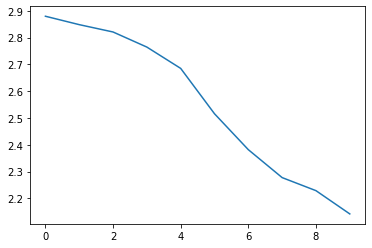

In [15]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluate the results with a confusion matrix! ##

C:\Users\jason\AppData\Local\Temp/ipykernel_8012/3315315813.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\jason\AppData\Local\Temp/ipykernel_8012/3315315813.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


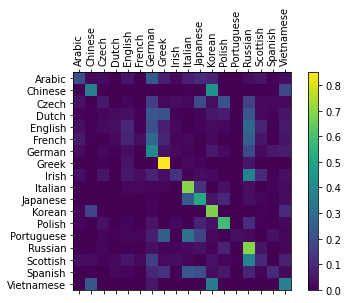

In [16]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden()
    line_tensor = line_tensor.to(device)

    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor, model_basic)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Now we can try predicting our own things! ##

In [17]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_basic)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Alberto')


> Dovesky
(-1.59) Russian
(-1.60) Polish
(-2.29) Czech

> Jackson
(-1.48) Russian
(-2.04) Scottish
(-2.16) Irish

> Satoshi
(-1.48) Italian
(-1.62) Polish
(-1.78) Japanese

> Alberto
(-1.52) Italian
(-1.87) Spanish
(-2.10) Portuguese


### So now lets shift to using the RNN Module from Pytorch ###

In [18]:
def categoryToTensor(category):
#     tensor = torch.zeros([1, 1], dtype=torch.long)
#     tensor[0][0] = all_categories.index(category)
    tensor = torch.zeros([1, len(all_categories)], dtype=torch.long)
    tensor[0][all_categories.index(category)] = 1
    return tensor

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = categoryToTensor(category)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
#     print(category_tensor.shape)

category = Vietnamese / line = Han
category = Korean / line = Park 
category = German / line = Krause
category = Czech / line = Antonowitsch
category = Polish / line = Klimek
category = Irish / line = Giolla
category = Irish / line = Cennetig
category = Scottish / line = Brown
category = Irish / line = Dubhan
category = Korean / line = Yi


In [19]:
class RNNPytorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNPytorch, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True) # 1 is num_layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):

        hidden, output = self.rnn(x, hidden)

        #print(hidden.shape)
        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, 1, self.hidden_size)

In [20]:
def train_pytorch_model(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden(line_tensor.shape[1])
    model.zero_grad()
    line_tensor = line_tensor.permute(1, 0, 2)
#     print(line_tensor.shape)
    
#     print(category_tensor.shape)
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)
    
    # Iterate through the whole line!
    hidden = hidden.to(device)
    output, hidden = model(line_tensor, hidden)

    loss = criterion(output, torch.topk(category_tensor, 1).indices.view(-1))
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

#### Train from the RNN using pytorch approach ####

In [21]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_pytorch = RNNPytorch(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_pytorch = model_pytorch.to(device)
optimizer = optim.SGD(model_pytorch.parameters(), lr=learning_rate)

n_iters = 10000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_pytorch_model(category_tensor, line_tensor, optimizer, criterion, model_pytorch)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 50% (0m 5s) 1.9520 Assaf / Arabic ✓
10000 100% (0m 10s) 2.4150 Ferrara / Japanese ✗ (Italian)


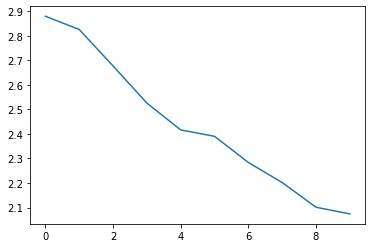

In [22]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [23]:
# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden(line_tensor.shape[1])
    hidden = hidden.to(device)

    line_tensor = line_tensor.permute(1, 0, 2)
    line_tensor = line_tensor.to(device)
    output, hidden = model(line_tensor, hidden)
    
    return output

In [24]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_pytorch)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Alberto')


> Dovesky
(-0.98) Polish
(-1.69) Russian
(-2.19) Czech

> Jackson
(-1.48) Russian
(-2.03) Scottish
(-2.12) Polish

> Satoshi
(-0.97) Polish
(-1.66) Italian
(-2.18) Czech

> Alberto
(-1.23) Italian
(-1.61) Portuguese
(-2.01) Spanish


# Lab Assignment below:
## Now one of your assigments is to adapt/expand this text classifier! ##

- Adapt the task to another similar task
- Use LSTMs or GRU to compare with both Vanilla RNN approaches

You can keep it at character-level or you can extend it to word-level (the vocabulary will change)

Try with different datasets with a similar Input/Output system:
- Book or character name -> writer
- Game's titles -> company or genre
- Any word -> language
- Whatever you can think it can be classified

In [25]:

txt_file = "C:/Users/jason/Python/Jason/Done/2-language-models-lab/data/book-summaries/booksummaries_public/booksummaries/booksummaries.txt"
file_in=open(txt_file,encoding='utf-8')

a = set()
arr = []
author_list = []
n_authors = 30
book = []
a_s = []
authors = []
data = {}
words=set()
titles = []

while len(a_s) < n_authors: #
    line = file_in.readline()
    line_strip = line.strip()
    line_split = line_strip.split('\t')
    if len(line_split[3]) != 0:
        author = line_split[3].title()
        author = line_split[3].replace(" ","")
        a_s.append(author) #
    
for line in file_in:
    line_strip = line.strip()
    line_split = line_strip.split('\t')
    arr.append(line_split)
    if author in a_s: #
        title=line_split[2]#.lower()
        title_split=title.split(" ")
        for w in title_split:
            words.add(w)
            
for paragraph in arr:
    if len(paragraph[3]) != 0:
        #print(paragraph[3])
        a.add(paragraph[3])
        

old_author = ""
for author in a:
    author = author.title()
    author = author.replace(" ", "")
    old_author = author
    if author in a_s: 
        for p in arr: #paragraph
            for word in p: #word in paragraph
                word = word.title()
                word = word.replace(" ", "")
                if author == word:
                    new_author = p[3]
                   # print(p[2], p[3])
                    if new_author != old_author:
                        titles.append(book)
                        old_author = new_author
                        book = []
                    if p[2] not in book:
                       #print("adding", book)
                        book.append(p[2]) # add books that are not in list
                       
                    if p[3] not in authors:
                        authors.append(p[3]) # add authors that are not in list
                        
file_in.close()

if not titles[0]:
    titles = titles[1:]

words.add(" ")  
words=list(words)
n_words=len(words)

for i in range(0, len(authors)):
    authors[i] = authors[i].title()
    authors[i] = authors[i].replace(" ", "")
    
for i in range(1, len(book)):
    book[i] = book[i].title()
    book[i] = book[i].replace(" ", "")
    
for key in authors:
    data[key] = []


for i in range(0, len(titles)):
    data[authors[i]] = titles[i]


#print("titles: ", titles)
#print("authors:", authors)
#print("data:", data)

        

In [26]:
# do some data processing, remove authors without books that has came into our data.
data = dict(compress(data.items(), data.values()))
authors = authors[:-2]  
print("titles: ", titles)
print("authors:", authors)
print("data:", data)  


titles:  [['Nostromo', 'The Secret Agent', 'Lord Jim', 'The Rover', "Almayer's Folly", 'Typhoon', 'Under Western Eyes', 'Amy Foster', 'Victory'], ['Consciousness Explained', 'Elbow Room', 'Freedom Evolves', 'Breaking the Spell: Religion as a Natural Phenomenon'], ['Macbeth', 'Othello', 'Romeo and Juliet', 'The Merchant of Venice', 'Cymbeline', "A Midsummer Night's Dream", 'Henry V', 'King Lear', 'Julius Caesar', 'Titus Andronicus', 'Measure for Measure', "All's Well That Ends Well", 'The Taming of the Shrew', 'Antony and Cleopatra', 'King John', "Love's Labour's Lost", 'Richard II', "The Winter's Tale", 'Richard III', 'Henry VI, part 1', 'Henry VI, part 3', 'The Merry Wives of Windsor', 'Henry IV, Part 1', 'Pericles, Prince of Tyre', 'The Two Gentlemen of Verona', 'Timon of Athens', 'Troilus and Cressida', 'The Comedy of Errors', 'Venus and Adonis', 'Twelfth Night, or What You Will', 'Henry IV, Part 2', 'Coriolanus', 'Much Ado About Nothing', 'As You Like It', 'The Tempest'], ['The Wor

In [27]:
# Find word index from all words
def wordToIndex(word):
    return words.index(word)

# Turn a title into a tensor
# <title_length x 1 x n_words>
def titleToTensor(title):
    if isinstance(title, str):
        tensor = torch.zeros(len(title.split(" ")), 1, n_words)
        for li, word in enumerate(title.split(" ")):
            tensor[li][0][wordToIndex(word)] = 1
        return tensor

# Turn a author into a tensor
def authorToTensor(author):
    tensor = torch.zeros([1, len(authors)], dtype=torch.long)
    tensor[0][list(data.keys()).index(author)] = 1
    return tensor

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    author = randomChoice(authors)
    title = randomChoice(data[author])
    author_tensor = authorToTensor(author)
    title_tensor = titleToTensor(title)
    return author, title, author_tensor, title_tensor

# Helper function to get the actual category from the best
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return authors[category_i], category_i

def getAuthorFromTitle(title):
    for author in data:
        for ti in data.get(author):
            if ti == title:
                return author
    return None

for i in range(5):
    author, title, author_tensor, title_tensor = randomTrainingExample()
    print('author =', author, '/ title =', title)
    

#print(titleToTensor(randomChoice(titles)))
#print(categoryFromOutput(output)
#getAuthorFromTitle("Uncle Silas")


author = K.W.Jeter / title = The Mandalorian Armor
author = AnthonyBurgess / title = A Clergyman's Daughter
author = J.R.R.Tolkien / title = The Ungoverned
author = JohnIrving / title = The Hotel New Hampshire
author = ErichMariaRemarque / title = Whose Body?


In [28]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.tanh_act = nn.Tanh()
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):

        hidden, output = self.gru(x, hidden)
        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        output = self.tanh_act(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, 1, self.hidden_size)

In [29]:
def train_pytorch_model(author_tensor, title_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden(title_tensor.shape[1])
    model.zero_grad()
    title_tensor = title_tensor.permute(1, 0, 2)
#     print(title_tensor.shape)
    
#     print(author_tensor.shape)
    author_tensor = author_tensor.to(device)
    title_tensor = title_tensor.to(device)
    
    # Iterate through the whole line!
    hidden = hidden.to(device)
    output, hidden = model(title_tensor, hidden)

    loss = criterion(output, torch.topk(author_tensor, 1).indices.view(-1))
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()


In [30]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 256

model_pytorch = GRU(n_words, N_HIDDEN, len(authors)) #Vocab_size, hidden size, output classes
model_pytorch = model_pytorch.to(device)
optimizer = optim.SGD(model_pytorch.parameters(), lr=learning_rate)

n_iters = 80000
print_every = 10000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_pytorch_model(category_tensor, line_tensor, optimizer, criterion, model_pytorch)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        print("current loss", current_loss)
        current_loss = 0

current loss 2938.423464536667
current loss 2926.5565328598022
current loss 2907.114103078842
current loss 2895.3669080734253
current loss 2884.8009293079376
current loss 2861.9258003234863
current loss 2845.2205817699432
current loss 2823.895723581314
current loss 2805.7318000793457
10000 12% (0m 42s) 2.5914 Three Comrades / GeorgeOrwell ✓
current loss 2771.643550157547
current loss 2733.0957320928574
current loss 2718.222158551216
current loss 2676.758485674858
current loss 2662.033959507942
current loss 2611.541328072548
current loss 2573.7283239364624
current loss 2562.329514503479
current loss 2515.3956065177917
current loss 2469.842162966728
20000 25% (1m 26s) 2.5491 The Two Towers / RayBradbury ✓
current loss 2448.5989381074905
current loss 2401.7729481458664
current loss 2365.3115686178207
current loss 2315.247356772423
current loss 2280.9888758659363
current loss 2260.879120707512
current loss 2203.766655445099
current loss 2174.1854597330093
current loss 2110.948921442032
cur

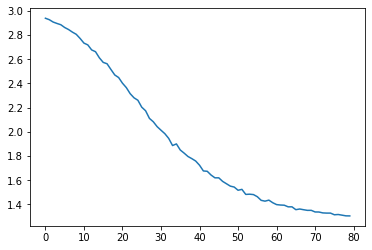

In [31]:
# PLOT THE RESULT
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [32]:
# Just return an output given a line
def evaluate(title_tensor, model):
    model.eval()
    hidden = model.initHidden(title_tensor.shape[1])
    hidden = hidden.to(device)

    title_tensor = title_tensor.permute(1, 0, 2)
    title_tensor = title_tensor.to(device)
    output, hidden = model(title_tensor, hidden)
    
    return output

In [33]:
def predict(input_line, n_predictions=3):
    print('\n> %s -' % input_line, getAuthorFromTitle(input_line))
    with torch.no_grad():
        output = evaluate(titleToTensor(input_line), model_pytorch)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s ' % (value, authors[category_index]))
            predictions.append([value, authors[category_index]])

#Predicting three authors for the word(s) given
predict(randomTrainingExample()[1])
predict(randomTrainingExample()[1])
predict('A Prayer')


> The Other Wind - UrsulaK.LeGuin
(-1.41) UrsulaK.LeGuin 
(-2.71) FranzKafka 
(-3.00) Voltaire 

> Lair of the White Worm - FrankHerbert
(-1.24) FrankHerbert 
(-3.20) DorothyL.Sayers 
(-3.20) RayBradbury 

> A Prayer - None
(-2.72) WilliamShakespeare 
(-2.91) J.R.R.Tolkien 
(-2.91) JosephConrad 
